In [1]:
import tensorflow as tf
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [2]:
import pandas as pd
import dict_map as dm

df = pd.read_csv('data/trainingdata300.csv',escapechar="\\",sep=",",error_bad_lines=False,warn_bad_lines=False)
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.dropna(inplace=True)
# df = df.head(500000)
# print(len(df))
# df = df.groupby('satzId').filter(lambda x: len(x) <= 300)
# print(df)
token2idx, idx2token = dm.get_dict_map(df, 'token')
tag2idx, idx2tag = dm.get_dict_map(df, 'tag')

df['Word_idx'] = df['Wort'].map(token2idx)
df['Tag_idx'] = df['Attribut'].map(tag2idx)
# print(df)

df_group = df.groupby(by = ['satzId'], as_index=False)['Wort', 'Attribut', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
#df_group
import pad_train_test as ptt
train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = ptt.get_pad_train_test_val(df_group, df, tag2idx)

input_dim = len(list(set(df['Wort'].to_list())))+1
output_dim = 32
input_length = max([len(s) for s in df_group['Word_idx'].tolist()])
n_tags = len(tag2idx)
# print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

<ipython-input-2-bd2227b86672>:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_group = df.groupby(by = ['satzId'], as_index=False)['Wort', 'Attribut', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))


train_tokens length: 26331 
train_tags length:   26331 
val_tokens length:   8778 
val_tags length:     8778 
test_tokens length:  3902 
test_tags length:    3902


In [5]:
import model as md
model_bilstm_lstm = md.get_bilstm_lstm_model(input_dim, output_dim, input_length, n_tags)

#choco install graphviz, pip install pydot
#from tensorflow.keras.utils import plot_model 
#plot_model(model_bilstm_lstm)

import numpy as np
model, history = md.train_model(train_tokens, np.array(train_tags), 
                                val_tokens, np.array(val_tags), 
                                model_bilstm_lstm)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 32)           3307040   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 64)           16640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 32)           12416     
_________________________________________________________________
time_distributed (TimeDistri (None, 300, 7)            231       
Total params: 3,336,327
Trainable params: 3,336,327
Non-trainable params: 0
_________________________________________________________________
{0: 374.2857142857143, 1: 237.07382953181272, 2: 236.775373179066, 3: 50.55196114193561, 4: 0.1443412670262642, 5: 24.712496245870458, 6: 1628.3858998144713}
Epoch 1/50
412/412 [==============================] - 176s 414ms/step - loss: 1.4403 -

In [6]:
# Save the model
filepath = './models/l300e50wWeights'
# save_model(md, filepath)
model.save(filepath)

INFO:tensorflow:Assets written to: ./models/l300e50wWeights\assets


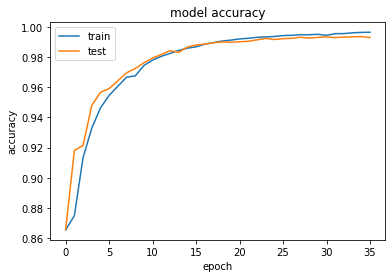

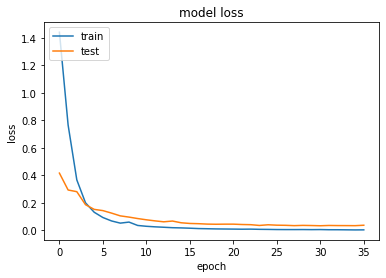

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_tokens, np.array(test_tags), batch_size=64)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(test_tokens[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
61/61 [==============================] - 4s 60ms/step - loss: 0.0346 - accuracy: 0.9931
test loss, test acc: [0.03460494801402092, 0.9931351542472839]
Generate predictions for 3 samples
predictions shape: (3, 300, 7)


In [60]:
predictions.shape

(3, 300, 7)

In [69]:
pred_tag_ids = predictions[2].argmax(axis=1)
pred_tag_ids

array([5, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], d

In [70]:
test_tokens[2]

array([ 88232,  81543,  47619,  72462,  41711,  13546,  38612,  84255,
        19384,  30061, 100865,  48086,  67041,  18830,  46805,  89852,
        76387,  59184,  83992,  68227,  27476,  25018,  73316,  83895,
        32574, 101363,  43079,  97105,  23872,  87266,  46374,  73290,
        19439,  99288,  27476,  93106,  34565,  85415,  13097,  43079,
        97417,  89852,   9635,  46167,  66773,  74492, 101363,  17029,
        46167,  74046,  79756,  86334,  55319,  80378,  38514,   5026,
        97900,  75795,  46719,  27476,  34589,  45653,  66584,  32579,
        93727,  63780,  96628,   8989,  36136,  87578,   3631,  27476,
        46051,  37507,  33490,  17831,   5602,  88232,  35316,  67041,
        46167,  63780,  96628,  25341, 101363,  55319,   2756,  87578,
        14181, 101363,  46167,  34687,  23976,  37507,  67041, 101251,
        29854,  93727,  95309,  89852,  46167,  23181,  37507,  67041,
         5021,   5026,  73316,  70775,  83895, 103216,  93106,  41371,
      

In [14]:
df_zu_testzwecken = pd.DataFrame(data=[0,1,2,3,4,5,6], columns=['IDX'])
df_zu_testzwecken['Tag'] = df_zu_testzwecken['IDX'].map(idx2tag)
print(df_zu_testzwecken)

   IDX            Tag
0    0        E-Brand
1    1  I-Modelnumber
2    2  E-Modelnumber
3    3  B-Modelnumber
4    4              O
5    5        B-Brand
6    6        I-Brand


In [ ]:
dfs = df.head(10000)
size = dfs.satzId.value_counts() > 500
print(size)
dfs = dfs.groupby('satzId').filter(lambda x: len(x) < 500)
size = dfs.satzId.value_counts() >= 500
print(size)

<AxesSubplot:ylabel='Frequency'>

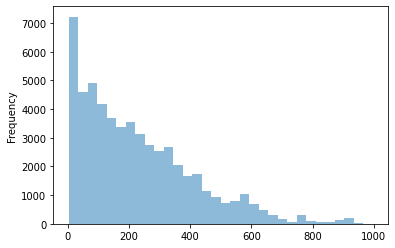

In [19]:
df.satzId.value_counts().plot.hist(bins=32, alpha=0.5)